# Dynesty - fitting real Kepler light curves

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u
import scipy
from scipy import signal


from astropy.io import fits

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

import dynesty

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

import random

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
nwalk = 64
nsteps_d = 1500
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [94]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

In [95]:
spectplanets = pd.read_csv('spectplanets.csv')
muirhead_comb = pd.read_csv('muirhead_comb.csv')
muirhead_comb_lums = pd.read_csv('muirhead_comb_lums.csv')
muirhead_lamost = pd.read_csv('muirhead_lamost.csv')

In [96]:
KICs = np.sort(np.unique(np.array(muirhead_comb['KIC'])))
KOIs = np.sort(np.unique(np.array(muirhead_comb['KOI'])))

In [97]:
KOIs

array(['1078', '1085', '1141', '1146', '1201', '1393', '1397', '1408',
       '1422', '1427', '1459', '1649', '1681', '1686', '1702', '1725A',
       '1725B', '1843', '1867', '1868', '1879', '1880', '1902', '1907',
       '2006', '2036', '2057', '2058', '2090', '2130', '2156', '2179',
       '2191', '2238', '2306', '2329', '2347', '2417', '2418', '2453',
       '247', '248', '249A', '249B', '250', '251', '252', '253', '254',
       '2542', '255', '256', '2626', '2650', '2662', '2704', '2705',
       '2715', '2764', '2839', '2842', '2845', '2862', '2926', '2992',
       '3010', '3034', '3090', '3119', '314', '3140', '3144', '3263',
       '3282', '3284', '3414', '3444', '3497', '3749', '4087', '4252',
       '4290', '4427', '4463SE', '463', '478', '4875', '531', '571',
       '596', '641', '739', '781', '812', '817', '818', '854', '886',
       '898', '899', '936', '947', '952', '961', '977'], dtype=object)

In [98]:
strkois = [str(i) for i in KOIs]

In [99]:
strkois = ['KOI ' + i for i in strkois]

In [100]:
# Some of these are false positives, e.g. KOI 961

# KOIs

In [101]:
#np.savetxt('MuirheadKOIs.txt', strkois, fmt='%s')

In [102]:
lcpath = '/Users/ssagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/datafiles/sample_LCs/'
lclist = []

for i in range(len(KICs)):
    templst = []
    for subdir, dirs, files in os.walk(lcpath):
        for file in files:
            if str(KICs[i]) in file:
                templst.append(os.path.join(subdir, file))
    lclist.append(templst)

In [103]:
KIC1 = 9710326

In [104]:
def get_stitched_lcs(KOI, KIC):
    
    files = lclist[int(np.argwhere(KICs==KIC))]
    #print(np.argwhere(KICs==KIC))
    #print(files)

    files = sorted(files)
    
    time = []
    flux = []
    flux_err = []
    hdus = []
    
    starttimes = []
    stoptimes = []
    
    for file in files:
        #print(file)
        hdu = fits.open(file)
        
        time_p = list(hdu[1].data['TIME'] + hdu[1].header['BJDREFI'] + hdu[1].header['BJDREFF'])
        time.append(time_p)
        
        flux_p = hdu[1].data['PDCSAP_FLUX']
        flux_err_p = hdu[1].data['PDCSAP_FLUX_ERR']
        
        fmed = np.nanmedian(flux_p)

        start = hdu[1].header['TSTART'] + hdu[1].header['BJDREFI'] + hdu[1].header['BJDREFF']
        starttimes.append(start)
        
        stop = hdu[1].header['TSTOP'] + hdu[1].header['BJDREFI'] + hdu[1].header['BJDREFF']
        stoptimes.append(stop)
        
        #print(hdu[1].data['TIMECORR'])
        
        flux.append(list(flux_p/fmed))
        flux_err.append(list(flux_err_p/fmed))
        
        hdus.append(hdu)


        #hdu.close()
    
    return hdus, time, flux, flux_err, starttimes, stoptimes

In [105]:
hdus, t, f, fe, starts, stops = get_stitched_lcs('947', 9710326)
#hdus[0][1].header

In [106]:
alltime_noclip = []
allflux_noclip = []
allfluxerr_noclip = []

for sublist in t:
    for item in sublist:
        alltime_noclip.append(item)
        
for sublist in f:
    for item in sublist:
        allflux_noclip.append(item)
        
for sublist in fe:
    for item in sublist:
        allfluxerr_noclip.append(item)

In [107]:
def sigma_clip(time, flux, fluxerr, sig=4):
    for i in tqdm(range(len(flux))):
        if flux[i] > np.nanmean(flux) + sig*np.nanstd(flux) or flux[i] < np.nanmean(flux) - sig*np.nanstd(flux):
            time[i] = np.nan
            flux[i] = np.nan
            fluxerr[i] = np.nan
            
    return time, flux, fluxerr
            

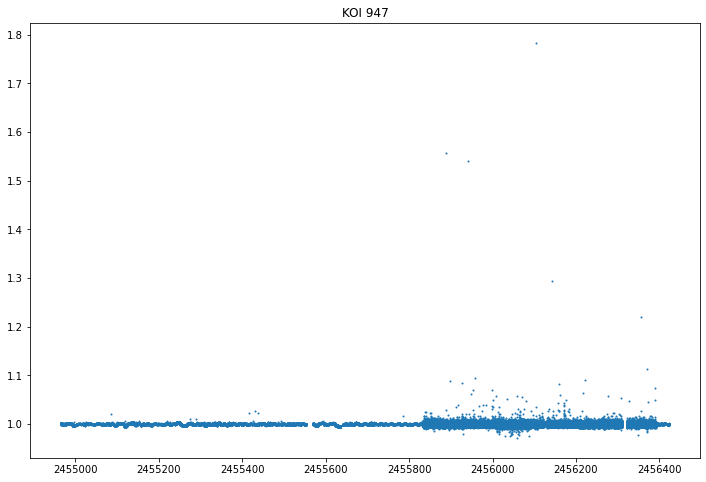

In [108]:
# alltime, allflux, allfluxerr = sigma_clip(alltime_noclip, allflux_noclip, allfluxerr_noclip, sig=4)

time, flux, flux_err = np.array(alltime_noclip), np.array(allflux_noclip), np.array(allfluxerr_noclip)

plt.scatter(time, flux, s=1)
plt.title('KOI 947')

plt.ticklabel_format(useOffset=False, style='plain')

# KOI 947

In [109]:
kepid = 9710326
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

In [110]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [111]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.48797798116154106 Stellar radius (Rsun):  0.4690682721275218
Period (Days):  28.59914031 Rp/Rs:  0.036375
a/Rs:  65.99499728728715
i (deg):  89.99


In [112]:
transitmpt = 2455022.92667000

In [113]:
midpoints = np.concatenate((np.arange(transitmpt, starts[0], -period), np.arange(transitmpt, stops[-1], period)))

In [114]:
# plt.scatter(np.array(alltime)-2454833, allflux, s=2)

# for i in range(len(midpoints)):
#     plt.axvline(midpoints[i]-2454833, c='r')
    
# #plt.axvline(2454967, c='g')
# #plt.axvline(2454967 + period, c='g')
# #plt.axvline(2454965.72900, c='b')
# #plt.axvline(2455022.92667000-period, c='k')
    
# #plt.xlim(alltime[0], alltime[-1])
# #plt.ylim(0.99,1.06)
# plt.xticks(ticks=np.arange(175, 260, 5))
# plt.ticklabel_format(useOffset=False, style='plain')
    

In [115]:
# medfilt = scipy.signal.medfilt(allflux, kernel_size=101)

# plt.scatter(np.array(alltime)-2454900.0, allflux-medfilt+1, s=2)

# #plt.scatter(np.array(alltime)-2454900.0, allflux, s=2)
# #plt.plot(np.array(alltime)-2454900.0, medfilt)

# for i in range(len(midpoints)):
#     plt.axvline(midpoints[i]-2454900.0, c='r')
    
# # plt.axvline(2454967-2454900.0, c='g')
# # plt.axvline(2454967-2454900.0 + period, c='g')
# # plt.axvline(2454965.72900-2454900, c='b')
    
# #plt.xlim(0, 100)
# #plt.ylim(0.998, 1.001)
# #plt.xticks(ticks=np.arange(100, 200, 5))
# plt.ticklabel_format(useOffset=False, style='plain')

In [116]:
#midpoints = np.unique(list(midjd[midjd['planetname'] == 'Kepler-737 b']['midpointjd']))
#midpoints_errs = np.unique(list(midjd[midjd['username'] == 'KOI ' + '947']['propmidpointunc']))

In [117]:
def get_KIC(KOI, muirhead_comb):
    return muirhead_comb[muirhead_comb['KOI'] == str(KOI)].KIC.item()

In [118]:
u = np.array([0,1])
u*0.2

array([0. , 0.2])

In [119]:
# def tfit_loglike(theta):
#     """
#     Transit fit dynesty function

#     model = ph.integratedlc_fitter()
#     gerr = sigma of g distribution

#     """

#     per, rprs, a_rs, inc, t0 = theta

#     model = ph.integratedlc_fitter(t1, per, rprs, a_rs, inc, t0)
#     sigma2 = fe1 ** 2
    
#     plt.plot(t1, fnorm)
#     plt.plot(t1, model)
#     plt.show()
    
#     return -0.5 * np.sum((fnorm - model) ** 2 / sigma2 + np.log(sigma2))


# def tfit_prior_transform(utheta):
#     """Transforms samples `u` drawn from the unit cube to samples to those
#     from our uniform prior within [-10., 10.) for each variable."""

#     uper, urp, ua, uinc, ut0 = utheta

#     per = uper*3.+27.
#     rprs = urp
#     a_rs = ua*15.+64.
#     inc = uinc*2.+88.
#     t0 = ut0*2.-1.

#     return per, rprs, a_rs, inc, t0

In [126]:
def fit_Kepler_lc(KOI, midpoints, time, flux, flux_err, period, nbuffer, spectplanets, muirhead_comb):
    
    # Get alt IDs
    kepid = get_KIC(KOI, muirhead_comb)
    kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]
    
    dr = str(KOI)
    direct = 'segfits/' + dr + '_dynesty/'

    if not os.path.exists(direct):
        os.mkdir(direct)
    
    # Get stellar params
    isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")
    
    mstar = isodf["mstar"].mean()
    mstar_err = isodf["mstar"].std()

    rstar = isodf["radius"].mean()
    rstar_err = isodf["radius"].std()
    
    # Get planet params
    period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

    # We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
    a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
    a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

#     print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
#     print('Period (Days): ', period, 'Rp/Rs: ', rprs)
#     print('a/Rs: ', a_rs)
#     print('i (deg): ', i)
            
    
    for ind in range(15, len(midpoints)):

        try:
        
            transitmid = midpoints[ind]

            tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

            t1 = np.array(time[tindex-nbuffer:tindex+nbuffer]) - transitmid
            t1bjd = np.array(time[tindex-nbuffer:tindex+nbuffer])
            
            f1 = np.array(flux[tindex-nbuffer:tindex+nbuffer])
            fe1 = np.array(flux_err[tindex-nbuffer:tindex+nbuffer])

            tindex = int(np.where(time == ph.find_nearest(time, transitmid))[0])

            idx = np.isfinite(t1) & np.isfinite(f1)

            disc = 5
            m, b = np.polyfit(np.concatenate((t1[idx][:disc], t1[idx][-disc:])), np.concatenate((f1[idx][:disc], f1[idx][-disc:])), 1)

            linfit = m*t1 + b
            fnorm = (f1-linfit)+1
            
            plt.cla()
            plt.errorbar(t1, f1, yerr=fe1, fmt='o', c='blue')
            plt.plot(t1, linfit, c='green')
            plt.xlabel('Time')
            plt.ylabel('Rel. Flux')
            plt.axvline(0, c='r')
            plt.savefig(direct + str(KOI) + 'segment' + str(ind) + '.png')

            mid = ph.get_mid(time)
            ptime = ph.get_ptime(t1, mid, 29)

            fnorm = np.nan_to_num(fnorm, nan=1.0)
            fe1 = np.nan_to_num(fe1, nan=np.nanmedian(fe1))

############################################################################################################
            
            def tfit_loglike(theta):
                """
                Transit fit dynesty function

                model = ph.integratedlc_fitter()
                gerr = sigma of g distribution

                """

                per, rprs, a_rs, inc, t0 = theta

                model = ph.integratedlc_fitter(t1, per, rprs, a_rs, inc, t0)
                sigma2 = fe1 ** 2
                
                return -0.5 * np.sum((fnorm - model) ** 2 / sigma2 + np.log(sigma2))


            def tfit_prior_transform(utheta):
                """Transforms samples `u` drawn from the unit cube to samples to those
                from our uniform prior within [-10., 10.) for each variable."""

                uper, urp, ua, uinc, ut0 = utheta

                per = uper*3.+27.
                rprs = urp
                a_rs = ua*15.+64.
                inc = uinc*2.+88.
                t0 = ut0*2.-1.

                return per, rprs, a_rs, inc, t0

            dsampler = dynesty.DynamicNestedSampler(tfit_loglike, tfit_prior_transform, ndim=5, nlive=1000,
                                        bound='multi', sample='rwalk')
            dsampler.run_nested()
            dres = dsampler.results
            
            # Thinning distributions to size arrlen

            pdist = random.choices(dres.samples[:,0], k=arrlen)
            rdist = random.choices(dres.samples[:,1], k=arrlen)
            adist = random.choices(dres.samples[:,2], k=arrlen)
            idist = random.choices(dres.samples[:,3], k=arrlen)
            t0dist = random.choices(dres.samples[:,4], k=arrlen)

            per_f = ph.mode(pdist)
            rprs_f = ph.mode(rdist)
            a_f = ph.mode(adist)
            i_f = ph.mode(idist)
            t0_f = ph.mode(t0dist)
            
            
############################################################################################################


            # Create a light curve with the fit parameters
            nestedfit = ph.integratedlc_fitter(t1, per_f, rprs_f, a_f, i_f, t0_f)
            truefit = ph.integratedlc_fitter(t1, period, rprs, a_rs, i, 0)

            plt.cla()
            offset = 2454900.0
            plt.errorbar(t1bjd-offset, fnorm, yerr=fe1, c='blue', alpha=0.5, label='Original LC', fmt="o", capsize=0)
            plt.scatter(t1bjd-offset, nestedfit, c='red', alpha=1.0, label='Fit LC')
            plt.plot(t1bjd-offset, nestedfit, c='red', alpha=1.0)
            plt.plot(t1bjd-offset, truefit, c='green', alpha=0.4)
            plt.xlabel('BJD-2454900.0')
            plt.ylabel(' Rel. Flux')
            
            textstr = '\n'.join((
            r'$\mathrm{Rp/Rs}=%.2f$' % (ph.mode(rdist), ),
            r'$\mathrm{a_rs}=%.2f$' % (ph.mode(adist), ),
            r'$\mathrm{i}=%.2f$' % (ph.mode(idist), ),
            r'$\mathrm{t0}=%.2f$' % (ph.mode(t0dist), )))
            plt.title(textstr)

            plt.legend()
            
            plt.savefig(direct + str(KOI) + 'segment' + str(ind) + 'fit.png')
            
            
        # Skip if transit mid-time falls outside of Kepler observations
        except TypeError:
            continue



In [ ]:
fit_Kepler_lc(947, midpoints, time, flux, flux_err, period, 11, spectplanets, muirhead_comb)

20438it [10:06, 33.70it/s, batch: 7 | bound: 223 | nc: 25 | ncall: 560170 | eff(%):  3.649 | loglstar: 142.788 < 151.747 < 149.526 | logz: 142.145 +/-  0.151 | stop:  0.910]      
23271it [11:10, 34.71it/s, batch: 8 | bound: 255 | nc: 25 | ncall: 650357 | eff(%):  3.578 | loglstar: 151.680 < 160.116 < 159.388 | logz: 148.964 +/-  0.172 | stop:  0.858]        
24349it [19:36:09,  2.90s/it, batch: 10 | bound: 260 | nc: 25 | ncall: 658415 | eff(%):  3.698 | loglstar: 155.513 < 164.510 < 163.820 | logz: 155.189 +/-  0.165 | stop:  0.996]  
20550it [45:52:12,  8.04s/it, batch: 7 | bound: 224 | nc: 25 | ncall: 561424 | eff(%):  3.660 | loglstar: 156.974 < 164.826 < 163.023 | logz: 153.322 +/-  0.174 | stop:  0.973]        
25994it [13:06, 33.04it/s, batch: 9 | bound: 287 | nc: 25 | ncall: 670624 | eff(%):  3.876 | loglstar: 155.345 < 164.309 < 163.269 | logz: 151.787 +/-  0.184 | stop:  0.845]       
24543it [11:38, 35.15it/s, batch: 9 | bound: 267 | nc: 25 | ncall: 657787 | eff(%):  3.731 |